# 训练情感分类器

这是[深圳技术大学2025秋季微专业课](https://hqyang.github.io/nlp-fall25/)使用的Jupyter Notebook。下面尝试基于数据进行训练。具体来说，它使用词袋提取特征，并使用朴素贝叶斯算法训练分类器。

它将接收文本`X`并返回一个`标签`，如果文本的情感类型是积极的，则为“1”，如果文本的情感类型是消极的，则为“-1”，如果文本的情感类型是中性的，则为“0”。
你可以在[Stanford Sentiment Treebank](http://nlp.stanford.edu/sentiment/index.html)运行此脚本测试你的分类器的准确性。 

## Setup

Setup code, do imports.

In [22]:
import numpy as np
from collections import defaultdict
from tqdm import tqdm
import random
import matplotlib.pyplot as plt

## 多项式朴素贝叶斯 Multinomial Naive Bayes

In [10]:
class MultinomialNaiveBayes:
    def __init__(self, alpha=1.0, classes=None):
        """
        初始化多项式朴素贝叶斯分类器
        :param alpha: 拉普拉斯平滑参数
        :param classes: 类别列表，默认为[-1, 0, 1]
        """
        self.alpha = alpha
        self.classes = classes if classes is not None else [-1, 0, 1]
        self.class_prior = defaultdict(float)  # 类别先验概率 P(c)
        self.word_likelihood = defaultdict(lambda: defaultdict(float))  # 词的条件概率 P(w|c)
        self.vocabulary = set()  # 词汇表
        self.class_total_words = defaultdict(int)  # 每个类别总词数

    def extract_features(self, x: str) -> dict[str, float]:
        """提取词袋特征，返回词到出现次数的映射"""
        features = {}
        for word in x.split(' '):
            features[word] = features.get(word, 0) + 1.0
        return features

    def fit(self, x_train: list[str], y_train: list[int]):
        """
        训练模型
        :param x_train: 训练文本列表
        :param y_train: 训练标签列表
        """
        # 重置模型参数
        self.class_prior.clear()
        self.word_likelihood.clear()
        self.vocabulary.clear()
        self.class_total_words.clear()
        
        # 统计词频和类别信息
        class_counts = defaultdict(int)  # 每个类别的样本数
        word_counts = defaultdict(lambda: defaultdict(int))  # 每个词在每个类别中的出现次数

        # 遍历所有训练样本
        for x, y in tqdm(zip(x_train, y_train), desc="Training", total=len(x_train)):
            class_counts[y] += 1
            features = self.extract_features(x)
            
            for word, count in features.items():
                self.vocabulary.add(word)
                word_counts[y][word] += count
                self.class_total_words[y] += count
        
        # 计算先验概率（带平滑）
        total_docs = len(x_train)
        num_classes = len(self.classes)
        for c in self.classes:
            self.class_prior[c] = np.log((class_counts[c] + self.alpha) / (total_docs + self.alpha * num_classes))
        
        # 计算似然概率（带拉普拉斯平滑）
        vocab_size = len(self.vocabulary)
        for c in self.classes:
            total_words = self.class_total_words[c]
            for word in self.vocabulary:
                word_count = word_counts[c][word]
                # 使用对数概率避免下溢
                self.word_likelihood[c][word] = np.log((word_count + self.alpha) / (total_words + self.alpha * vocab_size))

    def predict(self, x: str) -> int:
        """
        预测单个文本的标签
        :param x: 输入文本
        :return: 预测的标签
        """
        features = self.extract_features(x)
        scores = {}
        
        for c in self.classes:
            score = self.class_prior[c]  # 初始分数为类别先验
            for word, count in features.items():
                # 处理未登录词（使用平滑后的概率）
                if word in self.vocabulary:
                    score += count * self.word_likelihood[c][word]
            scores[c] = score
        
        return max(scores, key=scores.get)

    def score(self, x_data: list[str], y_data: list[int]) -> float:
        """
        计算模型在数据集上的准确率
        :param x_data: 文本列表
        :param y_data: 真实标签列表
        :return: 准确率
        """
        correct = 0
        total = len(x_data)
        for x, y in zip(x_data, y_data):
            if self.predict(x) == y:
                correct += 1
        return correct / total if total > 0 else 0.0

## Data Reading

Read in the data from the training and dev (or finally test) sets

In [3]:
def read_xy_data(filename: str) -> tuple[list[str], list[int]]:
    x_data = []
    y_data = []
    with open(filename, 'r') as f:
        for line in f:
            label, text = line.strip().split(' ||| ')
            x_data.append(text)
            y_data.append(int(label))
    return x_data, y_data

In [4]:
x_train, y_train = read_xy_data('../data/sst-sentiment-text-threeclass/train.txt')
x_dev, y_dev = read_xy_data('../data/sst-sentiment-text-threeclass/dev.txt')

In [5]:
print(x_train[0])
print(y_train[0])

The Rock is destined to be the 21st Century 's new `` Conan '' and that he 's going to make a splash even greater than Arnold Schwarzenegger , Jean-Claud Van Damme or Steven Segal .
1


## 模型训练与评估

In [24]:
# 初始化并训练模型
model = MultinomialNaiveBayes(alpha=1.0)
model.fit(x_train, y_train)

# 评估模型
train_accuracy = model.score(x_train, y_train)
dev_accuracy = model.score(x_dev, y_dev)

print(f'Train accuracy: {train_accuracy}')
print(f'Dev/test accuracy: {dev_accuracy}')

Training: 100%|██████████| 8544/8544 [00:00<00:00, 105308.40it/s]


Train accuracy: 0.858497191011236
Dev/test accuracy: 0.631244323342416


## 错误分析 Error Analysis 

改进任何系统的一个重要部分就是找出问题出在哪里。下面这个函数允许您随机观察一些错误的示例，这可能有助于您改进分类器。您也可以为错误分析编写更复杂的方法。

In [17]:
def find_errors(model: MultinomialNaiveBayes, x_data: list[str], y_data: list[int], num_examples=5):
    """查找并展示分类错误的样本"""
    error_ids = []
    y_preds = []
    
    for i, (x, y) in enumerate(zip(x_data, y_data)):
        y_pred = model.predict(x)
        y_preds.append(y_pred)
        if y != y_pred:
            error_ids.append(i)
    
    if not error_ids:
        print("No errors found!")
        return
        
    # 随机展示错误样本
    for _ in range(min(num_examples, len(error_ids))):
        idx = random.choice(error_ids)
        x, y_true, y_pred = x_data[idx], y_data[idx], y_preds[idx]
        print(f'Text: {x}')
        print(f'True label: {y_true}, Predicted label: {y_pred}\n')


In [20]:
# 展示错误样本
find_errors(model, x_dev, y_dev)

Text: The inhospitability of the land emphasizes the spare precision of the narratives and helps to give them an atavistic power , as if they were tales that had been handed down since the beginning of time .
True label: 0, Predicted label: 1

Text: A delirious celebration of the female orgasm .
True label: 0, Predicted label: 1

Text: Or emptying rat traps .
True label: -1, Predicted label: 0

Text: As befits its title , this PG-13-rated piffle is ultimately as threatening as the Snuggle Fabric Softener bear .
True label: 0, Predicted label: -1

Text: This is as respectful a film as Byatt fans could hope for , though lovers of the book may wonder why it 's necessary .
True label: 0, Predicted label: 1



## 不同平滑参数对性能的影响

Training: 100%|██████████| 8544/8544 [00:00<00:00, 74216.87it/s]


Alpha: 0.1, Train Acc: 0.9452, Dev Acc: 0.5876


Training: 100%|██████████| 8544/8544 [00:00<00:00, 155247.01it/s]


Alpha: 0.5, Train Acc: 0.9137, Dev Acc: 0.6222


Training: 100%|██████████| 8544/8544 [00:00<00:00, 152356.74it/s]


Alpha: 1.0, Train Acc: 0.8585, Dev Acc: 0.6312


Training: 100%|██████████| 8544/8544 [00:00<00:00, 142238.49it/s]


Alpha: 2.0, Train Acc: 0.7807, Dev Acc: 0.6285


Training: 100%|██████████| 8544/8544 [00:00<00:00, 146208.46it/s]


Alpha: 5.0, Train Acc: 0.7237, Dev Acc: 0.6094


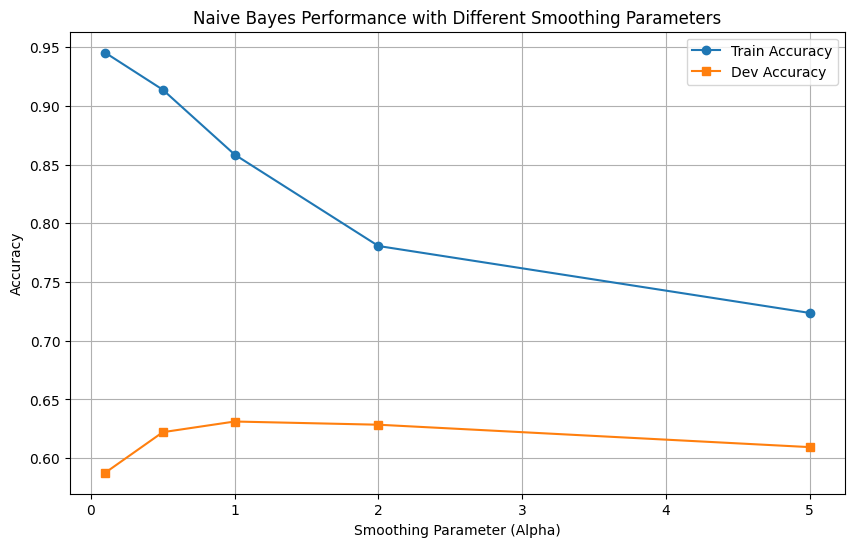

In [23]:
alphas = [0.1, 0.5, 1.0, 2.0, 5.0]
train_accs = []
dev_accs = []

for alpha in alphas:
    nb_model = MultinomialNaiveBayes(alpha=alpha)
    nb_model.fit(x_train, y_train)
    train_acc = nb_model.score(x_train, y_train)
    dev_acc = nb_model.score(x_dev, y_dev)
    train_accs.append(train_acc)
    dev_accs.append(dev_acc)
    print(f"Alpha: {alpha}, Train Acc: {train_acc:.4f}, Dev Acc: {dev_acc:.4f}")

# 绘制结果
plt.figure(figsize=(10, 6))
plt.plot(alphas, train_accs, marker='o', label='Train Accuracy')
plt.plot(alphas, dev_accs, marker='s', label='Dev Accuracy')
plt.xlabel('Smoothing Parameter (Alpha)')
plt.ylabel('Accuracy')
plt.title('Naive Bayes Performance with Different Smoothing Parameters')
plt.legend()
plt.grid(True)
plt.show()